In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [98]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [99]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [104]:
### Your code is here
num_cols = []
str_cols = []
for col in list(df.columns):
    if df[col].dtype == object:
        str_cols.append(col)
    else:
        num_cols.append(col)

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in str_cols:
    
    df[col] = df[col].fillna( df.groupby(col,as_index=False)[col].value_counts().sort_values(by='count', ascending=False)[col].iloc[0] )
  

In [112]:
### Секретные функции для фильтрации признаков

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[num_cols], 10))

Top Absolute Correlations
Var2                      Var3                  0.683437
Trip_Distance             Life_Style_Index      0.468332
Life_Style_Index          Var3                  0.303324
Customer_Rating           Var2                  0.302968
Trip_Distance             Var3                  0.231706
Customer_Rating           Var3                  0.227531
Life_Style_Index          Var2                  0.215944
Trip_Distance             Var2                  0.200456
Life_Style_Index          Customer_Rating       0.189165
Cancellation_Last_1Month  Surge_Pricing_Type    0.185646
dtype: float64


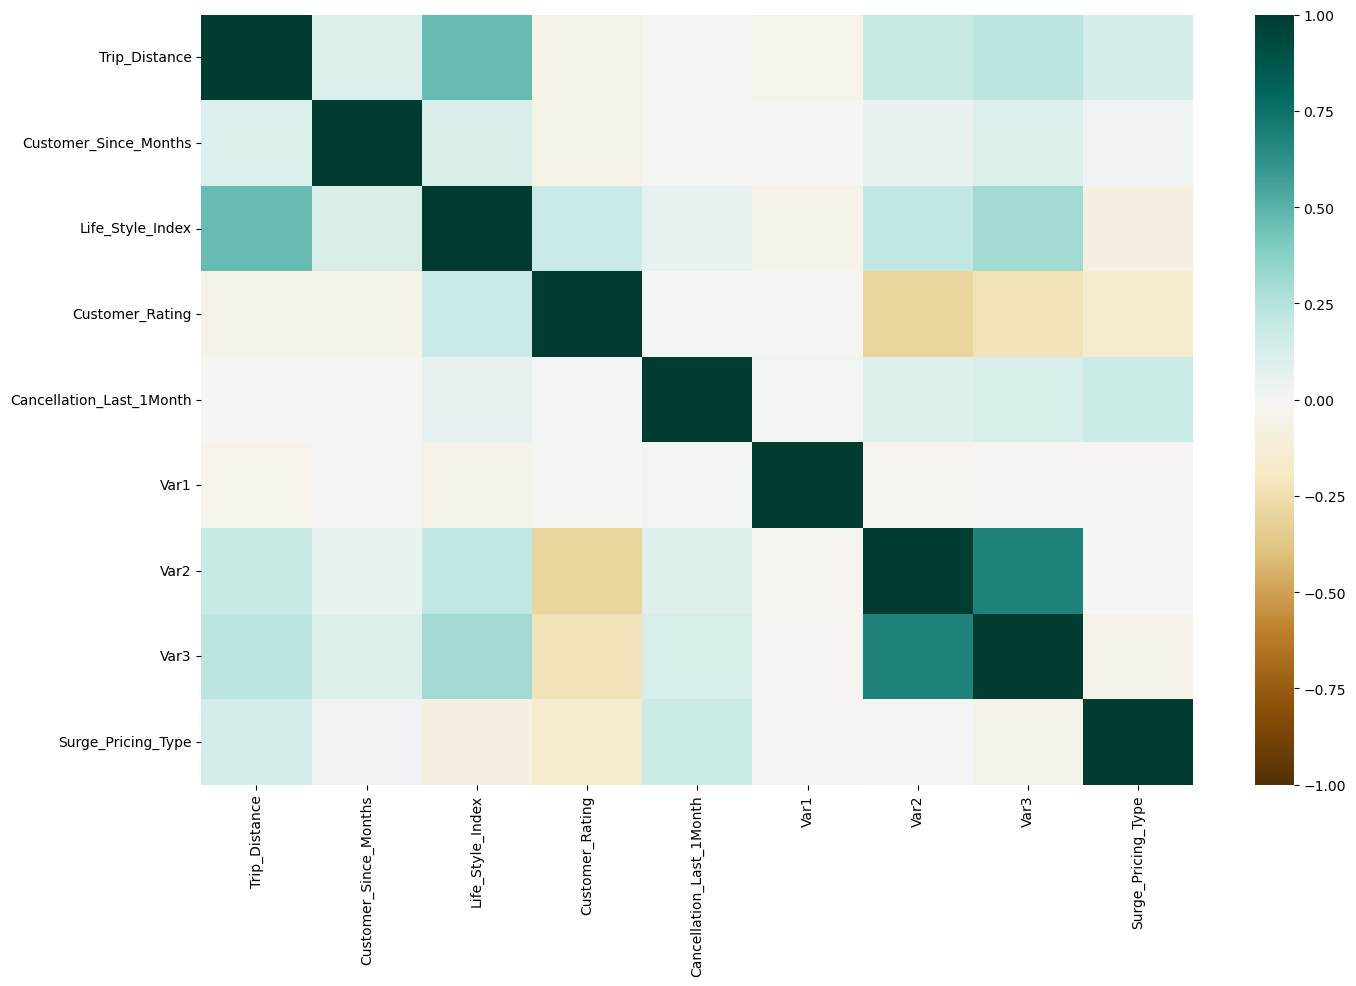

In [110]:
import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df[num_cols].corr(), 
            xticklabels=num_cols,
            yticklabels=num_cols,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

In [113]:
from sklearn.preprocessing import OneHotEncoder

for col in str_cols:
    
    ### Your code is here
    df = df.join(pd.get_dummies(df[col], prefix=col, drop_first=True))
    df = df.drop(columns=[col])

### Training

In [115]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [117]:
X = df.drop(columns=['Surge_Pricing_Type'])
y = df['Surge_Pricing_Type']

In [118]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [126]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Your code is here
pipe = Pipeline([('scaler', StandardScaler()),('one_vs_all', OneVsRestClassifier(estimator = LogisticRegression()))])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

In [132]:
print(classification_report(y_test, pred, labels=list(y.unique()), digits=3))

              precision    recall  f1-score   support

           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612
           1      0.723     0.542     0.619      5372

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [133]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [158]:
### Your code is here
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(pipe, param_grid)

In [159]:
search.fit(X_train, y_train)
pred_grid = search.predict(X_test)

In [136]:
print(classification_report(y_test, pred_grid, labels=list(y.unique()), digits=3))

              precision    recall  f1-score   support

           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612
           1      0.742     0.534     0.621      5372

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

In [138]:
### Your code is here

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [183]:
### Создание полиномиальных признаков

X_polinomial = X.copy()

for col in num_cols[:-1]:
    for power in [2, 3, 4]:
        
        to_add = (X_polinomial[col]**power).to_frame().rename({col:f"{col}_{power}"}, axis=1)
        X_polinomial = pd.concat((X_polinomial, to_add), axis=1)


In [184]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [167]:
search.best_params_

{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}

In [189]:
### Your code is here

### Your code is here
pipe_pol = Pipeline([('scaler', StandardScaler()),('one_vs_all', OneVsRestClassifier(estimator = LogisticRegression(C=0.001, penalty='l2')))])
pipe_pol.fit(X_pol_train, y_train)
pred_pol = pipe_pol.predict(X_pol_test)
print(classification_report(y_test, pred_pol, labels=list(y.unique()), digits=3))

              precision    recall  f1-score   support

           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612
           1      0.748     0.532     0.622      5372

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

In [187]:
### Your code is here


**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [172]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [173]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import classification_report

### Your code is here
pipe = Pipeline([('scaler', StandardScaler()),('one_vs_one', OneVsOneClassifier(estimator = SGDClassifier()))])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

In [175]:
print(classification_report(y_test, pred, labels=list(y.unique()), digits=3))

              precision    recall  f1-score   support

           2      0.626     0.870     0.728     11349
           3      0.756     0.536     0.627      9612
           1      0.748     0.521     0.614      5372

    accuracy                          0.677     26333
   macro avg      0.710     0.642     0.656     26333
weighted avg      0.698     0.677     0.668     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [174]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [176]:
### Your code is here
search = GridSearchCV(pipe, param_grid)

search.fit(X_train, y_train)
pred_grid = search.predict(X_test)
print(classification_report(y_test, pred_grid, labels=list(y.unique()), digits=3))

              precision    recall  f1-score   support

           2      0.633     0.845     0.724     11349
           3      0.745     0.572     0.647      9612
           1      0.748     0.529     0.620      5372

    accuracy                          0.681     26333
   macro avg      0.709     0.649     0.663     26333
weighted avg      0.697     0.681     0.675     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?